In [ ]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# !rm -r data/

In [ ]:
from google.colab import drive

# Unmount if already mounted
drive.flush_and_unmount()

# Mount again
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
teethPosition_dir = '/content/drive/MyDrive/DeepLearning/DentexDataSet/TeethPosition'

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=teethPosition_dir, transform=transform)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)



In [ ]:
import torch.nn as nn
from torchvision.models import resnet18

num_classes = len(dataset.classes)

model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Época {epoch+1}, perda: {running_loss / len(trainloader):.4f}')


Época 1, perda: 1.1713
Época 2, perda: 0.6107
Época 3, perda: 0.5059
Época 4, perda: 0.3923
Época 5, perda: 0.3871
Época 6, perda: 0.3126
Época 7, perda: 0.3201
Época 8, perda: 0.1963
Época 9, perda: 0.2360
Época 10, perda: 0.1578
Época 11, perda: 0.2114
Época 12, perda: 0.1522
Época 13, perda: 0.2030
Época 14, perda: 0.1644
Época 15, perda: 0.0776
Época 16, perda: 0.0943
Época 17, perda: 0.1603
Época 18, perda: 0.1969
Época 19, perda: 0.1064
Época 20, perda: 0.0624
Época 21, perda: 0.1953
Época 22, perda: 0.1239
Época 23, perda: 0.1499
Época 24, perda: 0.1350
Época 25, perda: 0.1141
Época 26, perda: 0.0494
Época 27, perda: 0.0180
Época 28, perda: 0.0234
Época 29, perda: 0.0304
Época 30, perda: 0.0215
Época 31, perda: 0.0280
Época 32, perda: 0.0946
Época 33, perda: 0.1395
Época 34, perda: 0.1748
Época 35, perda: 0.0779
Época 36, perda: 0.0984
Época 37, perda: 0.1397
Época 38, perda: 0.0900
Época 39, perda: 0.0741
Época 40, perda: 0.0798
Época 41, perda: 0.0697
Época 42, perda: 0.0258
É

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Acurácia: {100 * correct / total:.2f}%")


Acurácia: 86.12%


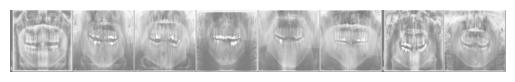

Ground Truth: 24 27 48 17 46 17 17 38
Predictions: 24 27 48 17 46 17 17 38


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

classes = dataset.classes  # ['11', '12', ..., '48']

def imshow(img):
    img = img / 2 + 0.5     # "desnormaliza"
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Ver um batch de imagens com rótulos reais e previstos
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Mostrar
imshow(torchvision.utils.make_grid(images.cpu()[:8]))
print("Ground Truth:", ' '.join(classes[label] for label in labels[:8]))
print("Predictions:", ' '.join(classes[p] for p in predicted[:8]))


In [ ]:
# Caminho para salvar o modelo
model_path = 'modelo_treinado.pth'

# Salva o estado do modelo (pesos)
torch.save(model.state_dict(), model_path)
print(f'Modelo salvo em: {model_path}')


Modelo salvo em: modelo_treinado.pth


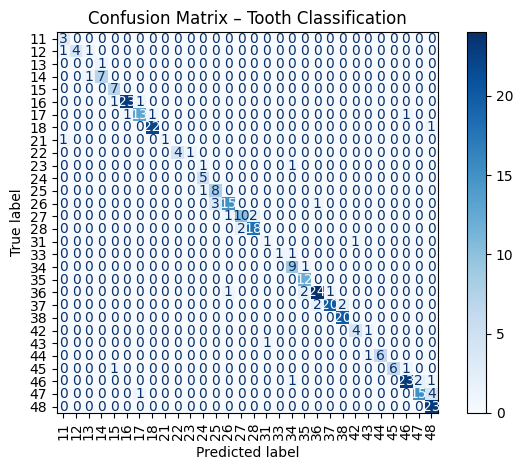

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

unique_labels = np.unique(np.concatenate((y_true, y_pred)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[dataset.classes[i] for i in unique_labels])
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix – Tooth Classification")
plt.tight_layout()
plt.show()

In [ ]:
fp = sum(1 for p, t in zip(y_pred, y_true) if p != t)
fp_per_image = fp / len(y_true)
print(f"FP per image: {fp_per_image:.2f}")

FP per image: 0.33


In [ ]:
print(dataset.classes)
print(len(dataset.classes))

['10', '11', '12', '13', '14', '15', '16', '17', '20', '21', '22', '23', '24', '25', '26', '27', '30', '31', '32', '33', '34', '35', '36', '37', '7']
25


In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44283 sha256=2d740798711246b5b56e67a7dcc8300a14e8ab845e3dea511cfbeb6a77a5a128
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


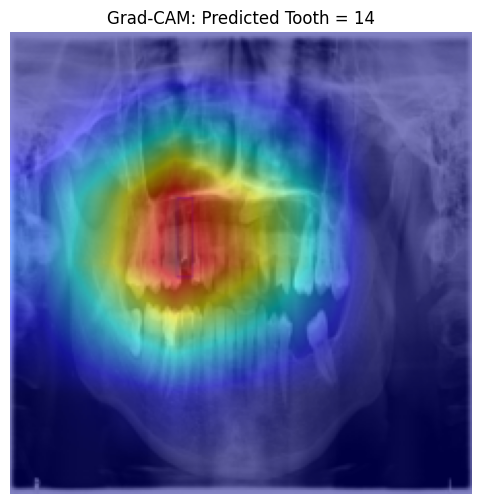

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision.transforms.functional import normalize

images, labels = next(iter(testloader))
image = images[7].unsqueeze(0).to(device)
label = labels[7].item()

target_layer = model.layer4[1].conv2

activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

forward_handle = target_layer.register_forward_hook(forward_hook)
backward_handle = target_layer.register_backward_hook(backward_hook)

model.eval()
output = model(image)
class_idx = output.argmax(dim=1).item()

model.zero_grad()
output[0, class_idx].backward()

acts = activations[0].detach().cpu()
grads = gradients[0].detach().cpu()

weights = grads.mean(dim=(2, 3), keepdim=True)
cam = (weights * acts).sum(dim=1).squeeze()

cam = torch.relu(cam)
cam = cam - cam.min()
cam = cam / cam.max()

cam = cam.numpy()
cam = np.uint8(cam * 255)


input_img = image.squeeze().detach().cpu().permute(1, 2, 0).numpy()
input_img = input_img - input_img.min()
input_img = input_img / input_img.max()

from pytorch_grad_cam.utils.image import show_cam_on_image


cam = np.maximum(cam, 0)
cam = cam - cam.min()
cam = cam / (cam.max() + 1e-8)


import cv2

cam_resized = cv2.resize(cam, (224, 224))

heatmap_img = show_cam_on_image(input_img.astype(np.float32), cam_resized, use_rgb=True)

plt.figure(figsize=(6, 6))
plt.imshow(heatmap_img)
plt.axis('off')
plt.title(f"Grad-CAM: Predicted Tooth = {dataset.classes[class_idx]}")
plt.show()